# CHECKPOINT
(1) a specification of the work to be performed (definition of the game or optimization problem to be
solved)

(2) related work with references to works found in a bibliographic search (articles, web pages,
and/or source code)

(3) formulation of the problem as an optimization problem (solution representation, neighborhood/mutation and crossover functions, hard constraints, evaluation functions)

(4) implementation work already carried out (programming language, development environment, data structures, among others).

In [138]:
import numpy as np
import itertools
#import matplotlib as pltlib
import math, copy
import random

table_arrangement = [[0,2], [1,3]]

test_preference_matrix = [
    [  0,  10,  -5,  20, -10,  15,   0,  -5],  # A
    [ 10,   0,  30,  -5,  20, -10,   5,   0],  # B
    [ -5,  30,   0,  10, -20,   5,  15,  10],  # C
    [ 20,  -5,  10,   0,  25,  -5, -15,  20],  # D
    [-10,  20, -20,  25,   0,  30, -10,   5],  # E
    [ 15, -10,   5,  -5,  30,   0,  20, -10],  # F
    [  0,   5,  15, -15, -10,  20,   0,  30],  # G
    [ -5,   0,  10,  20,   5, -10,  30,   0]   # H
] #ABCDABCD

In order to test with different sized preference matrices we created a function that randomly generates preference matrices given a number of guests

In [139]:
def random_preferences(nguests):
    preference_matrix = [[0] * nguests for x in range(nguests)]
    for guest1 in range(nguests):
        for guest2 in range(nguests):
            if guest1 != guest2:
                score = random.randrange(-100, 100, 1)
                preference_matrix[guest1][guest2] = score
                preference_matrix[guest2][guest1] = score
    return preference_matrix

p = random_preferences(4)

print(p)

[[0, -44, 6, -86], [-44, 0, -53, -49], [6, -53, 0, 8], [-86, -49, 8, 0]]


In [140]:
def evaluate_table(table, matrix):
    score = 0
    for guest in table:
        for neighbor in table:
            if guest != neighbor:
                score += matrix[guest][neighbor]

    return score

def standard_deviation(solution, preference_matrix):
    score_tables = []
    total_score=0
    for table in solution:
        current_score = evaluate_table(table, preference_matrix)
        total_score += current_score
        score_tables.append(current_score)
    average = total_score/len(solution)

    std_sum=0
    for score in score_tables:
        std_sum += (score-average)**2
    
    std = math.sqrt(std_sum/len(solution))
    return std

def evaluate_solution(solution, preference_matrix):
    average = average_tables(solution, preference_matrix)  #not optimal
    std = standard_deviation(solution, preference_matrix) + 1  # shift de 1 para nunca poder haver divisao por 0
    return (average/std)
    

def average_tables(tables, matrix):
    score = 0
    for table in tables:
        score += evaluate_table(table, matrix)
    average = score / len(tables)
    return average


score = evaluate_solution(table_arrangement, test_preference_matrix)
print(score)

-10.0


To be able to perform our algorithms correctly we will need all tables to be filled, so we will create fake guests called "EmptySeat" that have no preferences towards the other guests.

In [141]:
def fill_matrix(seatsPerTable, matrix):
    nguests = len(matrix)
    total_tables = math.ceil(nguests / seatsPerTable) #rounds the division up to the next integer
    TotalSeats = total_tables * seatsPerTable
    diff = TotalSeats % nguests 

    matrix_copy = copy.deepcopy(matrix)
    if diff == 0:
        return matrix_copy
    else:
        #fill the matrix with the preference that the guests have of the empty seats
        for guest in range(len(matrix_copy)):
            matrix_copy[guest] = matrix_copy[guest] + ([0]*diff)

        #fill the matrix with the preference of the emptyseats
        for i in range(diff):
            matrix_copy.append([0]*(nguests+diff))

    return matrix_copy

m = fill_matrix(3, test_preference_matrix)
print(m)

[[0, 10, -5, 20, -10, 15, 0, -5, 0], [10, 0, 30, -5, 20, -10, 5, 0, 0], [-5, 30, 0, 10, -20, 5, 15, 10, 0], [20, -5, 10, 0, 25, -5, -15, 20, 0], [-10, 20, -20, 25, 0, 30, -10, 5, 0], [15, -10, 5, -5, 30, 0, 20, -10, 0], [0, 5, 15, -15, -10, 20, 0, 30, 0], [-5, 0, 10, 20, 5, -10, 30, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0]]


Some of the algorithms we are applying to this problem, there is a need to create an initial random arrangement. That is what this function is for.

In [142]:
def random_arrangement(matrix, seatsPerTable):
    matrix_copy = fill_matrix(seatsPerTable, matrix)

    nguests = len(matrix_copy)
    guest_list = list(range(nguests))
    arrangement = []
    for table in range(nguests//seatsPerTable):
        table = random.sample(guest_list, seatsPerTable)
        for seatedGuest in table:
            guest_list.remove(seatedGuest)

        arrangement.append(table)
    return arrangement

def generate_population(population_size, preference_matrix, seatsPerTable):
    solutions = []
    for i in range(population_size):
        solutions.append(random_arrangement(preference_matrix, seatsPerTable))
    return solutions


r = random_arrangement(test_preference_matrix, 3)
print(r)

population = generate_population(3, test_preference_matrix, 2)
for solution in population:
    print(solution)

[[6, 1, 2], [4, 3, 0], [7, 8, 5]]
[[7, 0], [2, 6], [5, 1], [3, 4]]
[[0, 7], [6, 2], [3, 5], [4, 1]]
[[1, 7], [2, 6], [4, 5], [0, 3]]


In [143]:
toBeChanged = random.choices(range(1, int(8 * 0.05)+2))
print(toBeChanged)

[1]


All of our algorithms require some way to get a solution that is very similar to a given solution. In order to get that we built this function that changes a certain number of guests (based on the number of total guests).

In [144]:
#swaps two guests
def get_neighbour(curr_arrangement):
    neighbor_arrangement = copy.deepcopy(curr_arrangement)
    table1 = np.random.choice(len(neighbor_arrangement))
    table2 = np.random.choice(len(neighbor_arrangement))
    while(table1 == table2):
        table2 = np.random.choice(len(neighbor_arrangement))
    person1 = np.random.choice(len(neighbor_arrangement[table1]))
    person2 = np.random.choice(len(neighbor_arrangement[table2]))
    neighbor_arrangement[table1][person1], neighbor_arrangement[table2][person2] = neighbor_arrangement[table2][person2], neighbor_arrangement[table1][person1]
    return neighbor_arrangement
#improvement not filled table play

def advanced_get_neighbour(curr_arrangement):
    percentage = 0.05   #adjustable
    totalSeats = len(curr_arrangement)
    toBeChanged = random.choices(range(1, int(totalSeats*percentage)+2))
    
    neighbour_arrangement = curr_arrangement
    for nguests in range(toBeChanged[0]):
        neighbour_arrangement = get_neighbour(neighbour_arrangement)
    return neighbour_arrangement

advanced_get_neighbour(test_preference_matrix)

[[0, 10, -5, 20, -10, 15, 0, -5],
 [10, 0, 30, -5, 20, -10, 5, 0],
 [-5, 30, 0, 10, -20, 5, 15, 10],
 [20, -5, 10, 0, 25, -5, -15, 20],
 [-10, 20, -20, 25, 0, 30, -10, 5],
 [15, -10, 0, -5, 30, 0, 20, -10],
 [0, 5, 15, -15, -10, 20, 0, 30],
 [-5, 0, 10, 20, 5, -10, 30, 5]]

In [145]:
import random

# escolher a primeira metade das mesas de um dos pais e as restantes do outro pai ou se nao for possivel, aleatorio
def midpoint_crossover(parent1, parent2):
    num_tables = len(parent1)  # nº de mesas
    people_per_table = len(parent1[0])  # nº de pessoas por mesa

    # escolhe aleatoriamente qual solução usar primeiro
    if random.random() < 0.5:
        first_parent, second_parent = parent1, parent2
    else:
        first_parent, second_parent = parent2, parent1

    mid = num_tables // 2

    # filho com primeira metade das mesas do primeiro pai
    child = first_parent[:mid]
    used_elements = set(x for sublist in child for x in sublist)

    # adicionar a segunda metade das mesas do segundo pai sem repetir pessoas
    for sublist in second_parent[mid:]:
        new_sublist = [x for x in sublist if x not in used_elements]
        child.append(new_sublist)
        used_elements.update(new_sublist)

    all_elements = set(x for sublist in parent1 + parent2 for x in sublist)
    missing_elements = list(all_elements - used_elements)
    random.shuffle(missing_elements)  # os q faltam mete aleatoriamente

    # Redistribuir os que faltam mantendo o mesmo tamanho das sublistas
    for i in range(num_tables):
        while len(child[i]) < people_per_table:
            child[i].append(missing_elements.pop(0))

    return child

# Exemplo de uso
parent1 = [[0, 2], [1, 3], [4, 5], [6, 7]]
parent2 = [[1, 2], [6, 4], [0, 5], [3, 7]]

child = midpoint_crossover(parent1, parent2)
print(child)


[[1, 2], [6, 4], [5, 3], [7, 0]]


In [146]:
def random_crossover(parent1, parent2):
    num_tables = len(parent1)

    #print(len(parent1))
    #print(len(parent2))
    
    mask = [random.choice([0, 1]) for _ in range(num_tables)]
    
    mask[random.randint(0, num_tables - 1)] = 0  
    mask[random.randint(0, num_tables - 1)] = 1 
    
    child1, child2 = [[] for _ in range(num_tables)], [[] for _ in range(num_tables)]
    assigned1, assigned2 = set(), set()

    random.shuffle(parent1)
    random.shuffle(parent2)
    
    for i in range(num_tables):
        #print(i)
        if mask[i] == 0:
            child1[i] = [guest for guest in parent1[i] if guest not in assigned1]
            if child1[i] is not None: 
                assigned1.update(child1[i])
            child2[i] = [guest for guest in parent2[i] if guest not in assigned2]
            if child2[i] is not None: 
                assigned2.update(child2[i])
        else:
            child1[i] = [guest for guest in parent2[i] if guest not in assigned1]
            if child1[i] is not None: 
                assigned1.update(child1[i])
            child2[i] = [guest for guest in parent1[i] if guest not in assigned2]
            if child2[i] is not None: 
                assigned2.update(child2[i])
    
    all_guests = set(sum(parent1, []) + sum(parent2, []))  
    remaining1 = list(all_guests - assigned1)
    remaining2 = list(all_guests - assigned2)
    
    def fill_tables(child, remaining, parent_ref, assigned_set):
        random.shuffle(remaining)
        
        for i in range(num_tables):
            missing_count = len(parent_ref[i]) - len(child[i])
            if missing_count > 0:
                for guest in remaining[:missing_count]:
                    if guest not in assigned_set:
                        child[i].append(guest)
                        assigned_set.add(guest)
                remaining = remaining[missing_count:]  

    fill_tables(child1, remaining1, parent1, assigned1)
    fill_tables(child2, remaining2, parent2, assigned2)
    
    return child1, child2

# Exemplo de uso:
parent1 = [[0, 2], [1, 3], [4, 5], [6, 7], [8]]
parent2 = [[1, 2], [0, 4], [6, 5], [8, 7], [3]]

child1, child2 = random_crossover(parent1, parent2)

print("Filho 1:", child1)
print("Filho 2:", child2)


Filho 1: [[6, 5], [8, 7], [4, 2], [0, 1], [3]]
Filho 2: [[8, 6], [1, 3], [2, 7], [0, 4], [5]]


In [147]:
# escolhe pelo menos uma mesa de cada solução e o resto é aleatório, assumindo que todas as mesas têm o mesmo número de pessoas
def balanced_crossover(parent1, parent2):
    num_tables = len(parent1)
    people_per_table = len(parent1[0])

    child = []
    used_elements = set()

    chosen_from_p1 = random.choice(parent1)
    randomized_parent2 = random.sample(parent2, len(parent2))

    for table in randomized_parent2:
        flag=False
        for person in table:
            if person in chosen_from_p1:
                flag=True
                break
        
        if flag == False:
            chosen_from_p2 = table
            break

    used_elements.update(chosen_from_p1)
    used_elements.update(chosen_from_p2)
    child.append(chosen_from_p1)
    child.append(chosen_from_p2)

    print(child)

    table_sizes = [len(table) for table in parent1]

    for i in range(num_tables-2):
        if random.random() < 0.5:
            table = random.choice(parent1)
        else:
            table = random.choice(parent2)
        new_table = [x for x in table if x not in used_elements]
        child.append(new_table)
        used_elements.update(new_table)

    all_elements = set(x for sublist in parent1 + parent2 for x in sublist)
    missing_elements = list(all_elements - used_elements)
    random.shuffle(missing_elements)

    print(child)

    for i in range(num_tables):
        while len(child[i]) < table_sizes[i]:
            if missing_elements:
                child[i].append(missing_elements.pop(0))
    
    return child


parent1 = [[0, 2], [1, 3], [4, 5], [6, 7], [8]]
parent2 = [[1, 2], [0, 4], [6, 5], [8, 7], [3]]

child = balanced_crossover(parent1, parent2)
print(child)


[[4, 5], [8, 7]]
[[4, 5], [8, 7], [1, 2], [0], []]
[[4, 5], [8, 7], [1, 2], [0, 3], [6]]


**SIMMULATED ANNEALING**

In [148]:
def simmulated_annealing(preferences, seatsPerTable):
    cooling = 0.99    #o quao rápido vai descendo essa tolerancia
    iterations = 10000
    #primeiro arranjamos um estado inicial random e avaliamos
    initial_state = random_arrangement(preferences, seatsPerTable)
    filled_preferences=fill_matrix(seatsPerTable, preferences)
    initial_score = evaluate_solution(initial_state, filled_preferences)

    temperature = standard_deviation(initial_state, filled_preferences)   #basicamente a nossa tolerância no que toca a aceitar soluçoes piores
    print(temperature)

    while iterations > 0:

        #depois arranjamos uma soluçao vizinha à inicial e avaliamos essa
        neighbour_state = advanced_get_neighbour(initial_state)
        neighbour_score = evaluate_solution(neighbour_state, filled_preferences)
        

        score_diff = initial_score - neighbour_score

        #se a soluçao for melhor, aceitamos
        if score_diff < 0:
            initial_state = neighbour_state
            initial_score = neighbour_score
        #se for pior aceitamos com uma certa probabilidade que depende da temperatura
        else:
            probability = math.exp(-score_diff / temperature)
            if random.random() < probability:
                initial_state = neighbour_state
                initial_score = neighbour_score
        temperature *= cooling
        iterations -= 1
    return initial_state, initial_score


result, score = simmulated_annealing(test_preference_matrix, 3)
print(f"result: {result}    score: {score}")


4.714045207910317
result: [[0, 5, 3], [2, 1, 4], [8, 6, 7]]    score: 60.0


GENETIC ALGORTHIM

In [149]:
def tournament_select(population, preference_matrix, tournament_size, exclude=None):
    filtered_population = [ind for ind in population if ind != exclude]
    selected = random.sample(filtered_population, tournament_size)
    best_solution = max(selected, key=lambda s: evaluate_solution(s, preference_matrix))
    return best_solution

def roulette_select(population, preference_matrix, exclude=None):
    filtered_population = [ind for ind in population if ind != exclude]
    fitness_values = np.array([evaluate_solution(s, preference_matrix) for s in filtered_population])
    total_fitness = np.sum(fitness_values)
    rand_value = np.random.uniform(0, total_fitness)

    cumulative_sum = 0
    for i, fitness in enumerate(fitness_values):
        cumulative_sum += fitness
        if rand_value <= cumulative_sum:
            return filtered_population[i]
    


population = generate_population(5, test_preference_matrix, 2)
for s in population:
    print(s)
print("")   
t = tournament_select(population, test_preference_matrix, 3)
print(t)
print("")
r = roulette_select(population, test_preference_matrix)
print(r)


[[7, 0], [1, 4], [5, 3], [6, 2]]
[[7, 6], [4, 1], [3, 2], [0, 5]]
[[0, 7], [5, 2], [6, 3], [1, 4]]
[[0, 3], [5, 6], [1, 4], [2, 7]]
[[4, 1], [6, 3], [7, 2], [5, 0]]

[[0, 3], [5, 6], [1, 4], [2, 7]]

[[0, 3], [5, 6], [1, 4], [2, 7]]


In [150]:
def mutation(parent, mutation_prob=0.2):
    if random.random() < mutation_prob:  
        return get_neighbour(parent)
    return parent

MATRIZ PREFERENCIA
[[0, -45, -5, -36, -56, -13, -96, -68], [-45, 0, 75, -79, -22, -24, 69, -94], [-5, 75, 0, 33, 17, -54, 21, 18], [-36, -79, 33, 0, 76, -50, 14, 90], [-56, -22, 17, 76, 0, -58, -60, 11], [-13, -24, -54, -50, -58, 0, 48, 78], [-96, 69, 21, 14, -60, 48, 0, 64], [-68, -94, 18, 90, 11, 78, 64, 0]]
Initial solution: [[0, 1, 7], [4, 6, 2], [8, 3, 5]], score: -0.5770363219029305
  Final solution: [[1, 7, 4], [0, 3, 2], [8, 5, 6]], score: 8.167010404828968


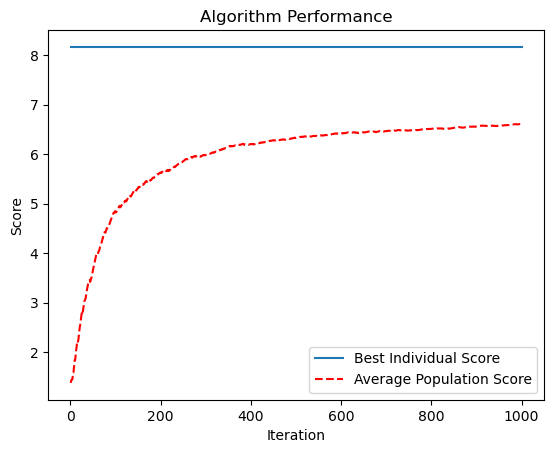

'genetic_algorithm(1, 100, p, 3)\ngenetic_algorithm(1, 100, p, 3)\ngenetic_algorithm(1, 100, p, 3)\ngenetic_algorithm(1, 100, p, 3)\ngenetic_algorithm(1, 100, p, 3)\ngenetic_algorithm(1, 100, p, 3)\ngenetic_algorithm(1, 100, p, 3)\ngenetic_algorithm(1, 100, p, 3)\ngenetic_algorithm(1, 100, p, 3)'

In [151]:
def genetic_algorithm(num_iterations, population_size, preference_matrix, seatsPerTable):
    filled_preference_matrix = fill_matrix(seatsPerTable, preference_matrix)
    population = generate_population(population_size, filled_preference_matrix, seatsPerTable)
    """print("population[0]: ")
    print(population[0])"""
    best_solution = population[0]
    best_score = evaluate_solution(population[0], filled_preference_matrix)
    num_iterations=1000
    
    best_scores = []
    all_scores = []
    avg_scores = []

    for solution in population:
        all_scores.append(evaluate_solution(solution, filled_preference_matrix))


    print(f"Initial solution: {best_solution}, score: {best_score}")

    while(num_iterations > 0):


        parent1 = tournament_select( population, filled_preference_matrix, 10)
        parent2 = tournament_select( population, filled_preference_matrix, 10, exclude=parent1)
        #parent2 = roulette_select(population, filled_preference_matrix, exclude=parent1)

        if parent2 is None:
            parent2 = parent1

        """print("parent 1:")
        print(parent1)
        print("parent2:")
        print(parent2)"""

        #estatisticas para grafico
        avg_score = np.mean(all_scores)
        avg_scores.append(avg_score)
        best_solution = max(population, key=lambda x: evaluate_solution(x, filled_preference_matrix))
        best_scores.append(evaluate_solution(best_solution, filled_preference_matrix))


        # Next generation Crossover and Mutation
        child1, child2 = random_crossover(parent1, parent2)

        """print("child 1:")
        print(child1)
        print("child2:")
        print(child2)"""

        child1, child2 = mutation(child1), mutation(child2)

        """print("mutate child 1:")
        print(child1)
        print("mutate child2:")
        print(child2)"""
        
        population.append(child1)
        population.append(child2)
        all_scores.append(evaluate_solution(child1, filled_preference_matrix))
        all_scores.append(evaluate_solution(child2, filled_preference_matrix))
        population.sort(key=lambda sol: evaluate_solution(sol, filled_preference_matrix), reverse=True)
        population = population[:population_size]

        """child = random_crossover(parent1, parent2)
        print("child 1:")
        print(child)

        child = mutation(child)

        print("mutate child 1:")
        print(child)
        population.append(child)
        population.sort(key=lambda sol: evaluate_solution(sol, filled_preference_matrix), reverse=True)
        population = population[:population_size]"""

        num_iterations-=1
    
    best_solution= population[0]
    best_score=evaluate_solution(best_solution, filled_preference_matrix)

    print(f"  Final solution: {best_solution}, score: {best_score}")

    show_graph(best_scores, avg_scores)
    return best_solution

p = random_preferences(8)
print("MATRIZ PREFERENCIA")
print(p)

genetic_algorithm(1, 100, test_preference_matrix, 3)
"""genetic_algorithm(1, 100, p, 3)
genetic_algorithm(1, 100, p, 3)
genetic_algorithm(1, 100, p, 3)
genetic_algorithm(1, 100, p, 3)
genetic_algorithm(1, 100, p, 3)
genetic_algorithm(1, 100, p, 3)
genetic_algorithm(1, 100, p, 3)
genetic_algorithm(1, 100, p, 3)
genetic_algorithm(1, 100, p, 3)"""

TABU SEARCH

In [152]:
def tabu_search(preferences, seats_per_table, max_iterations=1000, tabu_tenure=7, max_no_improve=100):
    padded_preferences = fill_matrix(seats_per_table, preferences)
    current_arrangement = random_arrangement(preferences, seats_per_table)
    best_arrangement = copy.deepcopy(current_arrangement)
    
    current_score = evaluate_solution(current_arrangement, padded_preferences)
    best_score = current_score
    
    tabu_list = {}
    
    iterations_no_improve = 0
    total_iterations = 0
    
    frequency_list = {}
    
    while total_iterations < max_iterations and iterations_no_improve < max_no_improve:
        total_iterations += 1
        
        neighbor_arrangement = get_neighbour(current_arrangement)
        
        neighbor_score = evaluate_solution(neighbor_arrangement, padded_preferences)
        
        is_tabu = tuple(map(tuple, neighbor_arrangement)) in tabu_list and tabu_list[tuple(map(tuple, neighbor_arrangement))] > 0
        
        if is_tabu and neighbor_score <= best_score:
            if tuple(map(tuple, neighbor_arrangement)) in frequency_list:
                frequency_list[tuple(map(tuple, neighbor_arrangement))] += 1
            else:
                frequency_list[tuple(map(tuple, neighbor_arrangement))] = 1
                
            if frequency_list.get(tuple(map(tuple, neighbor_arrangement)), 0) > 5:
                for _ in range(3):  
                    temp_neighbor = get_neighbour(current_arrangement)
                    current_arrangement = temp_neighbor
                current_score = evaluate_solution(current_arrangement, padded_preferences)
                frequency_list.clear()
            
            iterations_no_improve += 1
            continue
        
        current_arrangement = neighbor_arrangement
        current_score = neighbor_score
        
        keys_to_remove = []
        for arrangement, tenure in tabu_list.items():
            tabu_list[arrangement] -= 1
            if tabu_list[arrangement] <= 0:
                keys_to_remove.append(arrangement)
        
        for key in keys_to_remove:
            del tabu_list[key]
        
        tabu_list[tuple(map(tuple, current_arrangement))] = tabu_tenure
        
        if current_score > best_score:
            best_arrangement = copy.deepcopy(current_arrangement)
            best_score = current_score
            iterations_no_improve = 0
            frequency_list.clear()
        else:
            iterations_no_improve += 1
        
        if total_iterations % 100 == 0:
            print(f"Iteration {total_iterations}, Best score: {best_score}, No improvement: {iterations_no_improve}")
    
    original_guests = len(preferences)
    final_arrangement = []
    for table in best_arrangement:
        real_guests = [guest for guest in table if guest < original_guests]
        if real_guests:  
            final_arrangement.append(real_guests)
    
    return final_arrangement

In [153]:
tabu_search(test_preference_matrix, 3, max_iterations=1000, tabu_tenure=7, max_no_improve=100)

Iteration 100, Best score: 50.0, No improvement: 80


[[4, 3], [6, 7, 0], [2, 5, 1]]

GENETIC ALGORITHM (NEW VERSION)

Conversao para ser mais facil visualizar os convidados nas mesas 

In [154]:
from collections import defaultdict

def solution_to_tables(solution):
    mesas = defaultdict(list)
    for convidado, mesa in enumerate(solution):
        mesas[mesa].append(convidado)
    return list(mesas.values())


m=solution_to_tables([0, 0, 0, 1, 1, 1, 2, 2]
)

for i in m:
    print(i)

[0, 1, 2]
[3, 4, 5]
[6, 7]


In [155]:
def evaluate_table_(table, matrix):
    score = 0
    for guest in table:
        for neighbor in table:
            if guest != neighbor:
                score += matrix[guest][neighbor]

    return score

def standard_deviation_(tables, preference_matrix):
    solution = solution_to_tables(tables)
    score_tables = []
    total_score=0
    for table in solution:
        current_score = evaluate_table_(table, preference_matrix)
        total_score += current_score
        score_tables.append(current_score)
    average = total_score/len(solution)

    std_sum=0
    for score in score_tables:
        std_sum += (score-average)**2
    
    std = math.sqrt(std_sum/len(solution))
    return std

def evaluate_solution_(solution, preference_matrix):
    average = average_tables_(solution, preference_matrix)  #not optimal
    std = standard_deviation_(solution, preference_matrix) + 1  # shift de 1 para nunca poder haver divisao por 0
    return (average/std)
    

def average_tables_(solution, matrix):
    tables = solution_to_tables(solution)
    score = 0
    for table in tables:
        score += evaluate_table_(table, matrix)
    average = score / len(tables)
    return average

table_arrangement2=[0, 1, 0, 1]
score = evaluate_solution_(table_arrangement2, test_preference_matrix)
print(score)

-10.0


In [156]:
def generate_population_(pop_size, preference_matrix, seatsPerTable):
    num_guests = len(preference_matrix)
    num_tables = (num_guests + seatsPerTable - 1) // seatsPerTable
    population = []
    
    for _ in range(pop_size):
        guests = list(range(num_guests))
        random.shuffle(guests)
        individual = [0] * num_guests
        for i, guest in enumerate(guests):
            mesa = i // seatsPerTable
            individual[guest] = mesa
        population.append(individual)
    
    return population

population = generate_population_(5, test_preference_matrix, 2)
for s in population:
    print(s)

[0, 3, 1, 2, 3, 2, 1, 0]
[3, 1, 1, 0, 3, 2, 2, 0]
[3, 0, 2, 1, 0, 1, 3, 2]
[2, 3, 0, 1, 1, 0, 2, 3]
[1, 0, 3, 1, 2, 2, 3, 0]


In [157]:
def get_neighbour_(curr_arrangement):
    neighbor = curr_arrangement[:]
    num_guests = len(neighbor)

    # Escolher dois convidados diferentes
    guest1 = random.randint(0, num_guests - 1)
    guest2 = random.randint(0, num_guests - 1)
    while guest1 == guest2 or neighbor[guest1] == neighbor[guest2]:
        guest2 = random.randint(0, num_guests - 1)

    # Trocar as mesas atribuídas entre os dois convidados
    neighbor[guest1], neighbor[guest2] = neighbor[guest2], neighbor[guest1]

    return neighbor


In [158]:
from collections import Counter
import random

def random_crossover_(parent1, parent2, preference_matrix, seatsPerTable):
    num_guests = len(parent1)
    num_tables = (num_guests + seatsPerTable - 1) // seatsPerTable

    cut = random.randint(1, num_guests - 2)

    child1 = parent1[:cut] + parent2[cut:]
    child2 = parent2[:cut] + parent1[cut:]

    child1 = optimize_child(child1, num_tables, seatsPerTable, preference_matrix)
    child2 = optimize_child(child2, num_tables, seatsPerTable, preference_matrix)

    return child1, child2


def optimize_child(child, num_tables, seatsPerTable, preference_matrix):
    table_counts = Counter(child)

    # Mesas com mais do que o permitido
    overfilled = {mesa: count for mesa, count in table_counts.items() if count > seatsPerTable}
    # Mesas com espaço livre
    underfilled = {mesa: seatsPerTable - table_counts.get(mesa, 0) for mesa in range(num_tables) if table_counts.get(mesa, 0) < seatsPerTable}

    if not overfilled:
        return child  # solução já está válida

    # Identificar os convidados a mover (os que menos contribuem)
    guest_to_move = []
    for mesa in overfilled:
        guests = [i for i, m in enumerate(child) if m == mesa]
        guests_sorted = sorted(guests, key=lambda g: contribution_to_table(g, child, preference_matrix), reverse=True)
        needed = overfilled[mesa] - seatsPerTable
        guest_to_move.extend(guests_sorted[-needed:])  # mover os que contribuem menos

    # Mover os convidados para mesas com espaço
    underfilled_list = list(underfilled.items())  # [(mesa, lugares)]
    idx = 0
    for guest in guest_to_move:
        while idx < len(underfilled_list) and underfilled_list[idx][1] == 0:
            idx += 1
        if idx >= len(underfilled_list):
            break  # tudo alocado
        mesa_destino = underfilled_list[idx][0]
        child[guest] = mesa_destino
        underfilled_list[idx] = (mesa_destino, underfilled_list[idx][1] - 1)

    return child


def contribution_to_table(guest, solution, matrix):
    mesa = solution[guest]
    same_table = [i for i in range(len(solution)) if i != guest and solution[i] == mesa]
    return sum(matrix[guest][other] + matrix[other][guest] for other in same_table)


In [159]:
def tournament_select_(population, preference_matrix, tournament_size, exclude=None):
    filtered_population = [ind for ind in population if ind != exclude]

    if len(filtered_population) == 0:
        return exclude 

    #print("pop size: ")
    #print(len(filtered_population))
    # Corrigir o tamanho do torneio para nunca ultrapassar o tamanho da população
    tournament_size = min(tournament_size, len(filtered_population))

    selected = random.sample(filtered_population, tournament_size)
    best_solution = max(selected, key=lambda s: evaluate_solution_(s, preference_matrix))
    return best_solution


def roulette_select_(population, preference_matrix, exclude=None):
    filtered_population = [ind for ind in population if ind != exclude]
    fitness_values = np.array([evaluate_solution_(s, preference_matrix) for s in filtered_population])
    total_fitness = np.sum(fitness_values)
    rand_value = np.random.uniform(0, total_fitness)

    cumulative_sum = 0
    for i, fitness in enumerate(fitness_values):
        cumulative_sum += fitness
        if rand_value <= cumulative_sum:
            return filtered_population[i]
    


"""population = generate_population_(5, test_preference_matrix, 2)
for s in population:
    print(s)
print("")   
t = tournament_select_(population, test_preference_matrix, 3)
print(t)
print("")
r = roulette_select_(population, test_preference_matrix)
print(r)"""


'population = generate_population_(5, test_preference_matrix, 2)\nfor s in population:\n    print(s)\nprint("")   \nt = tournament_select_(population, test_preference_matrix, 3)\nprint(t)\nprint("")\nr = roulette_select_(population, test_preference_matrix)\nprint(r)'

In [160]:
def mutation_(parent, mutation_prob=0.1):
    if random.random() < mutation_prob:  
        return get_neighbour_(parent)
    return parent

MATRIZ PREFERENCIA
[[0, 34, 37, 63, -53, 66, -41, -71, 2, -2, 36, -78, -93, -51, -81, 36, 73, -52, 28, -14, 37, -40, 90, -45, 95, 93, 83, 4, -18, 26, -52, 88, 80, 43, 96, -76, -55, 90, -21, -90, -24, -99, -26, -56, 34, -3, 96, -83, -58, 36, -1, -61, -3, -12, 80, 76, -97, -52, 43, -88, 72, 8, 89, -22, 57, -27, 74, -95, -2, 23, -15, -18, 37, -40, 73, -90, -33, 61, -87, 56, 42, -85, 91, -24, 4, -93, -6, 64, -88, 11, -50, -29, -100, -67, -8, 30, -96, -82, 2, -67], [34, 0, -20, -57, -59, 87, -48, -27, 95, -90, -38, 81, 3, -87, -74, 99, -14, 5, 42, 78, -45, 28, 67, -94, 41, -87, -65, -43, 98, -55, -80, -54, 34, -51, 16, -15, 4, -66, 81, -26, 67, -46, 12, -64, 64, 35, 66, 73, 15, 85, 28, -90, -89, -48, 22, 21, -79, -76, -99, 0, 99, -71, 54, -72, 59, 67, -23, -37, -49, -73, 55, 79, -99, -34, -22, 42, -43, -34, 20, 96, -28, 9, 99, -82, -51, 64, -78, 84, 51, 55, 38, -100, -42, 73, 3, -63, 46, 31, 54, -18], [37, -20, 0, -47, 95, 11, -82, -54, 2, 13, 84, 33, 61, 64, 64, 53, 19, -70, 7, -48, 18, 23

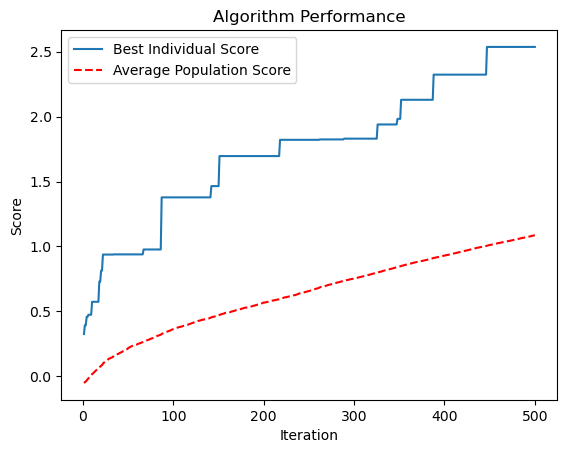

OLD:
Initial solution: [[86, 24, 44], [5, 76, 61], [6, 27, 88], [67, 90, 12], [96, 52, 100], [79, 46, 56], [63, 77, 41], [64, 93, 47], [92, 10, 39], [0, 74, 94], [60, 29, 68], [89, 33, 53], [59, 2, 23], [81, 55, 32], [31, 37, 97], [80, 98, 34], [69, 73, 48], [38, 57, 8], [66, 9, 50], [30, 85, 75], [83, 19, 82], [14, 91, 65], [70, 4, 17], [22, 45, 16], [21, 51, 36], [35, 72, 18], [54, 26, 43], [28, 20, 13], [40, 42, 1], [101, 84, 11], [49, 15, 62], [71, 87, 58], [78, 3, 7], [99, 95, 25]], score: 0.01494721163898499
  Final solution: [[65, 51, 52], [95, 11, 66], [54, 47, 64], [86, 3, 53], [30, 28, 14], [4, 79, 46], [24, 0, 6], [85, 41, 81], [5, 34, 21], [91, 7, 67], [23, 56, 49], [42, 15, 93], [76, 62, 10], [35, 89, 18], [43, 45, 59], [33, 20, 39], [29, 26, 68], [84, 48, 97], [13, 78, 98], [99, 96, 70], [31, 60, 77], [44, 61, 40], [22, 82, 27], [94, 32, 1], [2, 71, 12], [92, 83, 19], [90, 88, 55], [100, 63, 38], [73, 87, 25], [74, 16, 57], [101, 72, 50], [8, 17, 36], [75, 58, 37], [9, 69

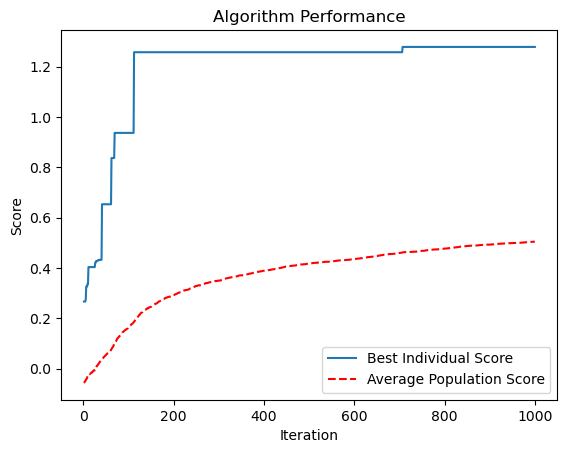

'genetic_algorithm(1, 100, test_preference_matrix, 3)\ngenetic_algorithm(1, 100, test_preference_matrix, 3)\ngenetic_algorithm(1, 100, test_preference_matrix, 3)\ngenetic_algorithm(1, 100, test_preference_matrix, 3)'

In [161]:
def genetic_algorithm_(num_iterations, population_size, preference_matrix, seatsPerTable):
    filled_preference_matrix = fill_matrix(seatsPerTable, preference_matrix)
    population = generate_population_(population_size, filled_preference_matrix, seatsPerTable)
    """print("population[0]: ")
    print(population[0])"""
    best_solution = population[0]
    best_score = evaluate_solution_(population[0], filled_preference_matrix)
    num_iterations=500

    best_scores = []
    all_scores = []
    avg_scores = []

    for solution in population:
        all_scores.append(evaluate_solution_(solution, filled_preference_matrix))
    

    print(f"Initial solution: {best_solution}, score: {best_score}")

    while(num_iterations > 0):

        #parent1 = tournament_select_( population, filled_preference_matrix, 10)
        parent1 = roulette_select_(population, filled_preference_matrix)
        #print(parent1)
        #parent2 = tournament_select_( population, filled_preference_matrix, 10, parent1)
        parent2 = roulette_select_(population, filled_preference_matrix, exclude=parent1)

        if parent2 is None:
            parent2 = parent1

        """print("parent 1:")
        print(parent1)
        print("parent2:")
        print(parent2)"""

        #estatisticas para grafico
        avg_score = np.mean(all_scores)
        avg_scores.append(avg_score)
        best_solution = max(population, key=lambda x: evaluate_solution_(x, filled_preference_matrix))
        best_scores.append(evaluate_solution_(best_solution, filled_preference_matrix))


        # Next generation Crossover and Mutation
        child1, child2 = random_crossover_(parent1, parent2, filled_preference_matrix, seatsPerTable)

        """print("child 1:")
        print(child1)
        print("child2:")
        print(child2)"""

        child1, child2 = mutation_(child1), mutation_(child2)

        """print("mutate child 1:")
        print(child1)
        print("mutate child2:")
        print(child2)"""
        
        population.append(child1)
        population.append(child2)
        all_scores.append(evaluate_solution_(child1, filled_preference_matrix))
        all_scores.append(evaluate_solution_(child2, filled_preference_matrix))
        population.sort(key=lambda sol: evaluate_solution_(sol, filled_preference_matrix), reverse=True)
        population = population[:population_size]


        """child = random_crossover(parent1, parent2)
        print("child 1:")
        print(child)

        child = mutation(child)

        print("mutate child 1:")
        print(child)
        population.append(child)
        population.sort(key=lambda sol: evaluate_solution(sol, filled_preference_matrix), reverse=True)
        population = population[:population_size]"""

        num_iterations-=1
    
    best_solution= population[0]
    best_score=evaluate_solution_(best_solution, filled_preference_matrix)
    print(f"  Final solution: {best_solution}, score: {best_score}")

    #print(best_scores)
    #print(avg_scores)
    show_graph(best_scores, avg_scores)

    return best_solution

p = random_preferences(100)
print("MATRIZ PREFERENCIA")
print(p)

t=[[0, 15, -21, 17, -73, -25, 56, 31, -48, -8], [15, 0, -14, 31, 75, 52, -28, -76, 43, 2], [-21, -14, 0, 30, -74, 58, -11, 97, 50, 20], [17, 31, 30, 0, 75, 57, 10, 95, 41, -26], [-73, 75, -74, 75, 0, 97, 88, 91, 75, -77], [-25, 52, 58, 57, 97, 0, -63, -3, 37, 21], [56, -28, -11, 10, 88, -63, 0, 2, -62, -94], [31, -76, 97, 95, 91, -3, 2, 0, 54, -76], [-48, 43, 50, 41, 75, 37, -62, 54, 0, 41], [-8, 2, 20, -26, -77, 21, -94, -76, 41, 0]]

"""genetic_algorithm_(1, 100, test_preference_matrix, 3)
genetic_algorithm_(1, 100, test_preference_matrix, 3)
genetic_algorithm_(1, 100, test_preference_matrix, 3)
genetic_algorithm_(1, 100, test_preference_matrix, 3)
genetic_algorithm_(1, 100, test_preference_matrix, 3)"""

print("NEW:")
genetic_algorithm_(1, 100, p, 3)
"""genetic_algorithm_(1, 100, test_preference_matrix, 3)
genetic_algorithm_(1, 100, test_preference_matrix, 3)
genetic_algorithm_(1, 100, test_preference_matrix, 3)
genetic_algorithm_(1, 100, test_preference_matrix, 3)"""

print("OLD:")
genetic_algorithm(1, 100, p, 3)
"""genetic_algorithm(1, 100, test_preference_matrix, 3)
genetic_algorithm(1, 100, test_preference_matrix, 3)
genetic_algorithm(1, 100, test_preference_matrix, 3)
genetic_algorithm(1, 100, test_preference_matrix, 3)"""


In [162]:
import matplotlib.pyplot as plt

def show_graph(best_scores, avg_scores):
    plt.plot(range(1, len(best_scores) + 1), best_scores, label='Best Individual Score')
    plt.plot(range(1, len(avg_scores) + 1), avg_scores, linestyle='--', color='red', label='Average Population Score')
    plt.xlabel('Iteration')
    plt.ylabel('Score')
    plt.title('Algorithm Performance')
    plt.legend()
    plt.show()